# Proyecto: 'CDMX Un aire no tan bueno'
## Licenciatura en Ciencia de Datos
### Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas (IIMAS)
### Universidad Nacional Autónoma de México

Integrantes:

- Ortega Ibarra Jaime Jesús
- Martiñón Luna Jonathan José

----
# Pre-Procesamiento de datos.

## Índice de contenidos
* [Importando librerías](#E1)
* [Lectura de Datos](#E2)
* [Generando Funciones](#E3)
* [Pre-procesando Datos](#E4)
* [Discriminando datos](#E5)
* [Gráficas](#E6)

----
<a name="E1"></a>
## Importando librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
from tabulate import tabulate
import re
import datetime
import swifter

----
<a name="E2"></a>
## Leyendo los datos

In [2]:
# Imeca2020
imeca_2020_df = pd.read_csv('../Datos/imeca_2020.csv')
#Calidad del aire
calidad_aire_df = pd.read_csv('../Datos/prueba_datos_calidad_aire.csv')
# Tiraderos clandestinos
tiraderos_clandestinos_df = pd.read_csv('../Datos/tiraderos-clandestinos-al-cierre-de-2017.csv')
# Nivel de plomo
nivel_plomo_df = pd.read_csv('../Datos/red_manual_plomo.csv',skiprows=8)
# Afluencia transporte
afluencia_transport_df = pd.read_csv('../Datos/afluencia-preliminar-en-transporte-publico.csv')
# Escuelas públicas
escuelas_publicas_df = pd.read_csv('../Datos/Escuelas/escuelas-publicas.csv')
# Escuelas privadas
escuelas_privadas_df = pd.read_csv('../Datos/Escuelas/escuelas-privadas.csv')
# Mercados
mercados_df = pd.read_csv('../Datos/mercados-publicos.csv')
# Parquímetros
parquimetros_df = pd.read_csv('../Datos/prueba-parquimetros.csv')
# Áreas Verdes
areas_verdes_df = pd.read_csv('../Datos/cdmx_areas_verdes_2017.csv')
# Áreas verdes con coordenadas
areas_verdes_Geo_df = gpd.read_file("../Datos/cdmx_areas_verdes_2017.geojson")
# Contador ciclistas
ciclistas_df = pd.read_csv('../Datos/contador-ciclistas.csv')
# Estaciones_Ecobici
estaciones_Ecobici_df = pd.read_csv('../Datos/estaciones-de-ecobici.csv')

#------------------
#Nota: Es importante descomprimir el archivo para poder leerlo.
# Contaminantes
contaminantes_df = pd.read_csv('../Datos/Contaminantes/contaminantes.csv')

----
<a name="E3"></a>
## Generando Funciones

In [3]:
def obten_dic_value_counts(objeto):
    '''
    @Author: Jonathan Martiñón
    
    @Descripción: 
                Función encargada de generar un diccionario
                a partir de los valores contados por pd.value_Counts()
                devuelve un diccionario donde el indice es el 'key' y
                el valor es 'value'
    '''
    Alcaldias = ['Benito Juarez','Tlahuac','Xochimilco','Tlalpan','Venustiano Carranza',
            'Milpa Alta', 'Miguel Hidalgo','Iztapalapa','Azcapotzalco','Cuajimalpa',
            'Cuauhtemoc', 'Alvaro Obregon', 'Magdalena Contreras', 'Coyoacan',
            'Gustavo A. Madero','Iztacalco']
    
    indices = objeto.index
    valores = objeto.values
    
    diccionario = dict(zip(indices,valores))
    
    for alcaldia in Alcaldias:
        if alcaldia not in indices:
            diccionario.update({alcaldia:0})
    
    return diccionario

In [4]:
def obten_alcaldia(direccion):
    '''
    @Author: Jonathan Martiñón
    
    @Descripción
            Para el dataset de escuelas tenemos cierta estructura
            donde la delegación viene incluída en el Domicilio.
            "DELEGACION x,". La presente función se encarga
            de extraer esa delegación.
    '''
    # Si tiene DELEGACION, hacemos un split
    dire = re.split("DELEGACION ",direccion)
    
    # Si el split se logra, tendrá al menos 2 elementos
    if len(dire)>1:
        # Nos interesa la segunda parte, que lleva una coma seguida
        # Lo quitamos y ajustamos a formato title
        alcaldia=dire[1].split(",")[0].title()
        
        #Datos atípicos
        if alcaldia == 'Cuajimalpa De Morelos':
            alcaldia = 'Cuajimalpa'
            
        elif alcaldia == 'Azcapotzalco Obregon':
            alcaldia = 'Azcapotzalco'
        elif alcaldia == 'Alvaro Obregón':
            alcaldia = 'Alvaro Obregon'
            
    # En caso de no encontrar delegación
    else:
        alcaldia = "No aplica"
    return alcaldia

In [5]:
def elimina_acentos_alcaldia(alcaldia):
    '''
    @Autor: Jonathan Martiñón
    
    @Descripción: 
            Función encargada de eliminar acentos en vocales para 
            una cadena.
    @Ejemplo
    alcaldia = 'Benito Juárez'
    elimina_acentos_alcaldia(alcaldia)
    >>> 'Benito Juarez'
    '''
    
    tildes = {"á":"a","é":"e","í":"i","ó":"o"}
    alcaldia = alcaldia.lower()
    for i in range(len(alcaldia)):
        
        if alcaldia[i] in list(tildes.keys()):
            
            alcaldia = alcaldia.replace(alcaldia[i],tildes[alcaldia[i]])
            
    return alcaldia.title()

In [6]:
def estacion_a_alcaldia(estacion):
    est_a_alc = {"Santa fe":"Cuajimalpa","Mguel Hidalgo":"Miguel Hidalgo",
                 "Pedregal":"Alvaro Obregon","Ajusco Medio":"Miguel Hidalgo",
                 "Coyoacán":"Coyoacan","Centro de Ciencias de la Atmósfera":"Coyoacan",
                 "UAM Xochimilco":"Xochimilco","UAM Iztapalapa":"Iztapalapa",
                 "Benito Juárez":"Benito Juarez","Santiago Acahualtepec":"Iztapalapa",
                 "Camarones":"Azcapotzalco","Hospital General de México":"Cuauhtemoc",
                 "Merced":"Venustiano Carranza","Ajusco":"Tlalpan"}
    
    Na = ['Nezahualcóyotl', 'San Agustín', 'Villa de las Flores','Acolman', 'Montecillo',
         'Investigaciones Nucleares','FES Aragón', 'Atizapan', 'Chalco','Tultitlán',
          'La Presa','San Juan Aragón','Xalostoc','Tlalnepantla','FES Acatlán',
         'Cuautitlán','Los Laureles']
    if estacion in Na:
        return "No aplica"
    elif estacion in list(est_a_alc.keys()):
        return est_a_alc[estacion]
    else:
        return estacion
        

In [7]:
def return_from_año(año,mes,datos):
    
    alcaldias = ['Cuajimalpa', 'Milpa Alta', 'Miguel Hidalgo', 'Alvaro Obregon',
       'Coyoacan', 'Tlahuac', 'Xochimilco', 'Iztapalapa', 'Benito Juarez',
       'Gustavo A. Madero', 'Azcapotzalco', 'Cuauhtemoc', 'Iztacalco',
       'Venustiano Carranza', 'Tlalpan']
    contaminantes = ['NO2', 'O3', 'SO2', 'PM10', 'PM2.5', 'CO', 'NO']
    
    cols = ['Contaminante']+alcaldias
    aux = pd.DataFrame(columns=cols)
    
    
    for contaminante in contaminantes:
        
        registro = [contaminante]
        
        for alcaldia in alcaldias:
            
            indice = (año,mes,contaminante,alcaldia)
            
            if indice in datos.index:
                registro.append(datos.loc[indice]['Valor'])
            else:
                registro.append(0)
                
        aux.loc[len(aux)] = registro
        
    return aux

In [8]:
def plotea(datos,mes,año='2020',save=False,formato='svg'):
    plt.figure(figsize=(12,8))

    cols = datos['Contaminante'].unique()
    for i in range(datos.shape[0]):

        x_values = datos.columns[1:]
        y_values = datos.iloc[i][1:].values
        plt.plot(x_values, y_values, label = cols[i], linestyle='-', marker='o')

    plt.xticks(rotation = 90,fontsize=20)
    plt.title('Contaminantes '+ mes +año,fontsize=30)
    plt.legend(loc='best',fontsize=11)
    plt.grid()
    plt.tight_layout()
    
    if save:
        plt.savefig('../Imagenes/'+mes+'.'+formato, format=formato)
    
    plt.show()

----
<a name="E4"></a>
## Pre-procesamiento

In [9]:
print(list(contaminantes_df.columns))
print(contaminantes_df.shape)
contaminantes_df.head()

['Fecha', 'Nombre de estación', 'Clave de estación', 'Clave Parámetro', 'Nombre de parámetro', 'Unidades parámetros', 'Valor', 'ID Unidad', 'Clave de unidad', 'Nombre de unidad', 'Altura Estación', 'Observación Estación', 'ID Estación', 'Latitud', 'Longitud', 'Coordenadas']
(469560, 16)


,Fecha,Nombre de estación,Clave de estación,Clave Parámetro,Nombre de parámetro,Unidades parámetros,Valor,ID Unidad,Clave de unidad,Nombre de unidad,Altura Estación,Observación Estación,ID Estación,Latitud,Longitud,Coordenadas
0,2020-02-15T20:00:00-06:00,Santa fe,SFE,NO2,Dióxido de nitrógeno,1,18.0,1,ppb,partes por billón,2599,NaN,484090040309,19.357357,-99.262865,"19.357357,-99.262865"
1,2020-02-15T20:00:00-06:00,Nezahualcóyotl,NEZ,NO2,Dióxido de nitrógeno,1,27.0,1,ppb,partes por billón,2235,NaN,484150580115,19.393734,-99.028212,"19.393734,-99.028212"
2,2020-02-15T20:00:00-06:00,San Agustín,SAG,O3,Ozono,1,8.0,1,ppb,partes por billón,2241,NaN,484150330327,19.532968,-99.030324,"19.532968,-99.030324"
3,2020-02-15T20:00:00-06:00,Villa de las Flores,VIF,O3,Ozono,1,6.0,1,ppb,partes por billón,2242,NaN,484150200109,19.658223,-99.096590,"19.658223,-99.09659"
4,2020-02-15T20:00:00-06:00,Milpa Alta,MPA,O3,Ozono,1,24.0,1,ppb,partes por billón,2594,NaN,484090090104,19.176900,-98.990189,"19.1769,-98.990189"


In [10]:
Alcaldias = ['Benito Juarez','Tlahuac','Xochimilco','Tlalpan','Venustiano Carranza',
            'Milpa Alta', 'Miguel Hidalgo','Iztapalapa','Azcapotzalco','Cuajimalpa',
            'Cuauhtemoc', 'Alvaro Obregon', 'Magdalena Contreras', 'Coyoacan',
            'Gustavo A. Madero','Iztacalco']

In [11]:
#Obtenemos las delegaciones que poseen una estación
Estac_list = list(contaminantes_df['Nombre de estación'].apply(estacion_a_alcaldia).unique())

In [12]:
#Convertimos los valores obtenidos a un diccionario
Estac_alc_dic = {alcaldia:(1 if alcaldia in Estac_list else 0) for alcaldia in Alcaldias}

In [13]:
# Obtenemos la cantidad de áreas verdes por delegación
areas_verdes_dic = obten_dic_value_counts(areas_verdes_df['delegacion'].apply(elimina_acentos_alcaldia).replace('Cuajimalpa De Morelos','Cuajimalpa').value_counts())

In [14]:
#Obtenemos la cantidad de parquímetros por alcaldía
parquimetros_dic = obten_dic_value_counts(parquimetros_df['Alcaldía'].apply(elimina_acentos_alcaldia).value_counts())

In [15]:
#Obtenemos la cantidad de mercados por alcaldía
mercados_dic = obten_dic_value_counts(mercados_df['alcaldia'].apply(str.title).value_counts())

In [16]:
# Obtenemos la cantidad de escuelas privadas por alcaldia
escuelas_privadas_dic = obten_dic_value_counts(escuelas_privadas_df['ALCALDÍA'].apply(str.title).replace('Cuajimalpa De Morelos',
                                                          'Cuajimalpa').replace('La Magdalena Contreras',
                                                                                'Magdalena Contreras').value_counts())

In [17]:
#Obtenemos la Alcaldía a partir del domicilio
escuelas_publicas_df['Alcaldia'] = escuelas_publicas_df['Domicilio con nombre'].apply(obten_alcaldia)

#Eliminamos aquellos lugares que no corresponden a la CDMX
escuelas_publicas_df.drop(escuelas_publicas_df[escuelas_publicas_df['Alcaldia']=='No aplica'].index
                          ,axis=0, inplace=True)

In [18]:
escuelas_publicas_dic = obten_dic_value_counts(escuelas_publicas_df['Alcaldia'].value_counts())

In [19]:
tiraderos_dic = obten_dic_value_counts(tiraderos_clandestinos_df.groupby('alcaldia')['alcaldia'].count())

#### Extrayendo datos promedio de contaminantes por delegación

In [48]:
delegaciones_estacion = []
for i in range(len(contaminantes_df)):
    estacion = contaminantes_df['Nombre de estación'][i]
    delegaciones_estacion.append(estacion_a_alcaldia(estacion))

contaminantes_df['Delegacion'] = delegaciones_estacion

In [49]:
contaminantes_alcaldia = contaminantes_df.groupby(['Delegacion','Nombre de parámetro']).mean().reset_index()

----
<a name="E5"></a>
## Discriminando Datos

De los valores que estamos seguros que nos servirán será la alcaldía

### Dataset por delegación

In [50]:
contaminantes_alcaldia_clean = contaminantes_alcaldia.drop(['ID Unidad', 'Latitud', 
                                                            'Longitud', 'ID Estación', 
                                                            'Altura Estación','Unidades parámetros'], axis=1)

In [51]:
deleg = ['Alvaro Obregon','Azcapotzalco','Benito Juarez','Coyoacan','Cuajimalpa',
                 'Cuauhtemoc','Gustavo A. Madero','Iztacalco','Iztapalapa','Miguel Hidalgo',
                    'Milpa Alta','No aplica','Tlahuac','Tlalpan','Venustiano Carranza','Xochimilco']

In [52]:
unidad_valor = contaminantes_alcaldia_clean.drop(['Delegacion'], axis=1)

In [53]:
df = pd.concat([unidad_valor.T[x] for x in unidad_valor.T], ignore_index=True)

In [54]:
dioxido_azufre = []
dioxido_nitrogeno = []
monoxido_carbono = []
ozono = []
particulas_10 = []
particulas_25 =[]
oxido_nitrico = []


for i in range(len(contaminantes_alcaldia_clean)):
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Dióxido de azufre':
        dioxido_azufre.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Dióxido de nitrógeno':
        dioxido_nitrogeno.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Monóxido de carbono':
        monoxido_carbono.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Ozono':
        ozono.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Partículas menores a 10 micrómetros':
        particulas_10.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Partículas menores a 2.5 micrómetros':
        particulas_25.append(contaminantes_alcaldia_clean['Valor'][i])
    if contaminantes_alcaldia_clean['Nombre de parámetro'][i] == 'Óxido nítrico':
        oxido_nitrico.append(contaminantes_alcaldia_clean['Valor'][i])   
contaminantes = [dioxido_azufre,dioxido_nitrogeno, monoxido_carbono, ozono, particulas_10, particulas_25,
                oxido_nitrico]

In [55]:
contaminantes_filtro = pd.DataFrame(contaminantes)
contaminantes_filtro = contaminantes_filtro.T
contaminantes_filtro.columns = ['Dióxido de azufre', 'Dióxido de nitrógeno', 'Monóxido de carbono',
                               'Ozono', 'Partículas menores a 10 micrómetros',
                                'Partículas menores a 2.5 micrómetros', 'Óxido nítrico']
contaminantes_filtro['Delegacion'] = deleg

In [56]:
data_df = pd.DataFrame(columns=['Alcaldia','Tiraderos','Escuelas_publicas',
                                'Escuelas_privadas','Mercados','Parquimetros',
                                'Areas_verdes','Estacion_climatologica'])
data_df.head()

,Alcaldia,Tiraderos,Escuelas_publicas,Escuelas_privadas,Mercados,Parquimetros,Areas_verdes,Estacion_climatologica


In [57]:
for alc in Alcaldias:
    data_df.loc[len(data_df)] = [alc,tiraderos_dic[alc],escuelas_publicas_dic[alc],
                                escuelas_privadas_dic[alc],mercados_dic[alc],
                                parquimetros_dic[alc],areas_verdes_dic[alc],
                                Estac_alc_dic[alc]]

In [59]:
join_data = data_df.join(contaminantes_filtro.set_index('Delegacion'), on='Alcaldia')
join_data

,Alcaldia,Tiraderos,Escuelas_publicas,Escuelas_privadas,Mercados,Parquimetros,Areas_verdes,Estacion_climatologica,Dióxido de azufre,Dióxido de nitrógeno,Monóxido de carbono,Ozono,Partículas menores a 10 micrómetros,Partículas menores a 2.5 micrómetros,Óxido nítrico
0,Benito Juarez,147,68,294,16,640,484,1,4.878558,24.420703,0.373232,27.691118,44.321968,19.178871,10.224626
1,Tlahuac,35,120,103,18,0,581,1,6.571570,15.921218,0.502914,34.260996,56.711430,22.918176,NaN
2,Xochimilco,12,95,149,11,0,196,1,NaN,NaN,NaN,32.722538,NaN,NaN,NaN
3,Tlalpan,2,78,325,20,0,735,1,3.190341,32.921460,0.363654,32.467337,NaN,19.595080,NaN
4,Venustiano Carranza,109,150,140,42,0,634,1,NaN,20.365634,NaN,25.872162,NaN,NaN,NaN
5,Milpa Alta,13,28,32,10,0,130,1,5.391106,6.654957,0.433097,45.713324,50.661931,21.590857,24.644358
6,Miguel Hidalgo,69,137,223,19,1382,925,1,2.299615,23.255269,0.137046,33.112762,NaN,NaN,6.655389
7,Iztapalapa,219,439,636,20,0,2129,1,4.963212,25.067006,0.330778,29.799185,36.472839,17.071155,19.736722
8,Azcapotzalco,47,156,126,19,0,960,1,6.837696,29.333492,0.461790,26.654926,53.044863,21.561505,22.885823
9,Cuajimalpa,5,35,172,5,0,448,1,3.350986,19.940796,0.268715,31.251996,39.920000,16.351495,13.150933


In [61]:
join_data.to_csv (r'Data_prep.csv', index=False)

### Dataset por tiempo

In [20]:
#Creamos un dataframe para extraer las características propias a cada alcaldía
data_Alcaldias_df = pd.DataFrame(columns=['Alcaldia','Tiraderos','Escuelas_publicas',
                                'Escuelas_privadas','Mercados','Parquimetros',
                                'Areas_verdes','Estacion_climatologica'])

In [21]:
#Llenamos nuestro dataframe con sus correspondientes datos
for alc in Alcaldias:
    data_Alcaldias_df.loc[len(data_Alcaldias_df)] = [alc,tiraderos_dic[alc],escuelas_publicas_dic[alc],
                                escuelas_privadas_dic[alc],mercados_dic[alc],
                                parquimetros_dic[alc],areas_verdes_dic[alc],
                                Estac_alc_dic[alc]]

#Convertimos el nombre de la alcaldía a nuestro índice    
data_Alcaldias_df.set_index('Alcaldia',inplace=True)

In [22]:
#Una pequeña visualización de la forma en que van quedando los datos
data_Alcaldias_df.head(2)

,Tiraderos,Escuelas_publicas,Escuelas_privadas,Mercados,Parquimetros,Areas_verdes,Estacion_climatologica
Alcaldia,,,,,,,
Benito Juarez,147,68,294,16,640,484,1
Tlahuac,35,120,103,18,0,581,1


In [23]:
def obten_valor_col(alcaldia,datos,col):
    '''
    @Autor: Jonathan Martiñón
    
    @Parametros:
    
    alcaldia  índice del DataFrame con valores de la alcaldía   STR
    datos     DataFrame con alcaldías como índices              pd.DataFrame
    col       Columna del DataFrame a extraer valor
    
    @Descripción:
            Función encargada de extraer características de la 
            alcaldía.
    @Devuelve:
    
    value   Valor obtenido del índice 'alcaldía' y la columna 'col'
    '''
    # Obtenemos el valor con el indice de la alcaldia actual
    # y columna 'col'
    value = datos[col][alcaldia]
    
    return value
    

In [24]:
def Genera_dataset(data,data_al):
    '''
    @Author: Jonathan Martiñón
    
    @Parametros:
    
    data1    Dataset que contiene los contaminantes              pd.DataFrame
    data2    Dataset que contiene informacion de las alcaldias   pd.DataFrame
    
    @Descripción:
            Función encargada de devolver el dataset Final.
            
    @Devuelve:
    
    data_df  DataFrame con los datos Finales.   LIST
    '''
    
    #Copiamos el dataset
    data_df = data.copy()
    
    #Obtenemos las alcaldías a partir de la estación
    data_df['Alcaldia'] = data_df['Nombre de estación'].swifter.apply(estacion_a_alcaldia)
    
    #Eliminamos aquellas alcaldías que no aplican a nuestro análisis
    data_df.drop(data_df[data_df['Alcaldia']=='No aplica'].index,axis=0,inplace=True)
    
    #Restauramos nuestro índice
    data_df.reset_index(drop = True, inplace=True) 
    
    #Convertimos la fecha a formato datetime para trabajar con ella
    data_df['Fecha']= pd.to_datetime(data_df['Fecha'])
    
    #Extraemos Día, Mes, Año y Hora de la Fecha
    data_df['Dia'] = data_df['Fecha'].swifter.apply(lambda x: x.day)
    data_df['Mes'] = data_df['Fecha'].swifter.apply(lambda x: x.month)
    data_df['Año'] = data_df['Fecha'].swifter.apply(lambda x: x.year)
    data_df['Hora'] = data_df['Fecha'].swifter.apply(lambda x: x.hour)
    
    #Eliminamos la fecha, pues ya no nos sirve
    data_df.drop(['Fecha'],axis=1,inplace=True)
    
    #Extraemos la cantidad de tiraderos por alcaldía
    data_df['Tiraderos'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                             datos=data_al,
                                                             col='Tiraderos').values
    #Extraemos la cantidad de escuelas públicas por alcaldía
    data_df['Escuelas_publicas'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                                     datos=data_al,
                                                                     col='Escuelas_publicas').values
    #Extraemos la cantidad de escuelas privadas por alcaldía
    data_df['Escuelas_privadas'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                                     datos=data_al,
                                                                     col='Escuelas_privadas').values
    #Extraemos la cantidad de mercados por alcaldía
    data_df['Mercados'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                            datos=data_al,
                                                            col='Mercados').values
    #Extraemos la cantidad de parquímetros por alcaldía
    data_df['Parquimetros'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                                datos=data_al,
                                                                col='Parquimetros').values
    #Extraemos la cantidad de áreas verdes por alcaldía
    data_df['Areas_verdes'] = data_df['Alcaldia'].swifter.apply(obten_valor_col,
                                                                datos=data_al,
                                                                col='Areas_verdes').values
    #Extraemos la cantidad de estaciones climatológicas por alcaldía
    data_df['Estacion_climatologica'] = data_df['Alcaldia'].apply(obten_valor_col,
                                                                  datos=data_al,
                                                                  col='Estacion_climatologica').values
    # Devolvemos el dataset generado
    return data_df

In [25]:
# Obtenemos los datos importantes del dataset
# de contaminantes
data_df = contaminantes_df[['Fecha','Nombre de estación','Clave de estación','Clave Parámetro',
                   'Nombre de parámetro','Unidades parámetros','Valor','ID Unidad',
                            'Clave de unidad']].copy(deep=True) 

In [26]:
# Damos una visualización de los datos
print(f"Contamos con {data_df.shape[0]} registros y {data_df.shape[1]} columnas")
data_df.head(2)

Contamos con 469560 registros y 9 columnas


,Fecha,Nombre de estación,Clave de estación,Clave Parámetro,Nombre de parámetro,Unidades parámetros,Valor,ID Unidad,Clave de unidad
0,2020-02-15T20:00:00-06:00,Santa fe,SFE,NO2,Dióxido de nitrógeno,1,18.0,1,ppb
1,2020-02-15T20:00:00-06:00,Nezahualcóyotl,NEZ,NO2,Dióxido de nitrógeno,1,27.0,1,ppb


In [27]:
#Generamos nuestro nuevo dataset con valores personalizados
# por alcaldía
data_df = Genera_dataset(data_df,data_Alcaldias_df)

Pandas Apply:   0%|          | 0/469560 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/248976 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/248976 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/248976 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/248976 [00:00<?, ?it/s]

In [28]:
#Almacenamos nuestro dataset
data_df.to_csv('./data_preprocessed.csv',index=False)

In [29]:
# Damos una visualización de los nuevos datos
print(f"Contamos con {data_df.shape[0]} registros y {data_df.shape[1]} columnas")
data_df.head()

Contamos con 248976 registros y 20 columnas


,Nombre de estación,Clave de estación,Clave Parámetro,Nombre de parámetro,Unidades parámetros,Valor,ID Unidad,Clave de unidad,Alcaldia,Dia,Mes,Año,Hora,Tiraderos,Escuelas_publicas,Escuelas_privadas,Mercados,Parquimetros,Areas_verdes,Estacion_climatologica
0,Santa fe,SFE,NO2,Dióxido de nitrógeno,1,18.0,1,ppb,Cuajimalpa,15,2,2020,20,5,35,172,5,0,448,1
1,Milpa Alta,MPA,O3,Ozono,1,24.0,1,ppb,Milpa Alta,15,2,2020,20,13,28,32,10,0,130,1
2,Mguel Hidalgo,MGH,O3,Ozono,1,27.0,1,ppb,Miguel Hidalgo,15,2,2020,20,69,137,223,19,1382,925,1
3,Pedregal,PED,O3,Ozono,1,19.0,1,ppb,Alvaro Obregon,15,2,2020,20,77,172,321,16,83,721,1
4,Ajusco Medio,AJM,O3,Ozono,1,NaN,1,ppb,Miguel Hidalgo,15,2,2020,20,69,137,223,19,1382,925,1


----
<a name="E5"></a>
## Discriminando Datos

In [30]:
Datos_G = data_df.groupby(['Año','Mes','Clave Parámetro','Alcaldia']).mean()

In [31]:
Diciembre_2019 = return_from_año(2019,12,Datos_G)
Enero_2020 = return_from_año(2020,1,Datos_G)
Febrero_2020 = return_from_año(2020,2,Datos_G)
Marzo_2020 = return_from_año(2020,3,Datos_G)
Abril_2020 = return_from_año(2020,4,Datos_G)
Mayo_2020 = return_from_año(2020,5,Datos_G)
Junio_2020 = return_from_año(2020,6,Datos_G)
Julio_2020 = return_from_año(2020,7,Datos_G)
Agosto_2020 = return_from_año(2020,8,Datos_G)
Septiembre_2020 = return_from_año(2020,9,Datos_G)
Octubre_2020 = return_from_año(2020,10,Datos_G)
Noviembre_2020 = return_from_año(2020,11,Datos_G)
Diciembre_2020 = return_from_año(2020,12,Datos_G)

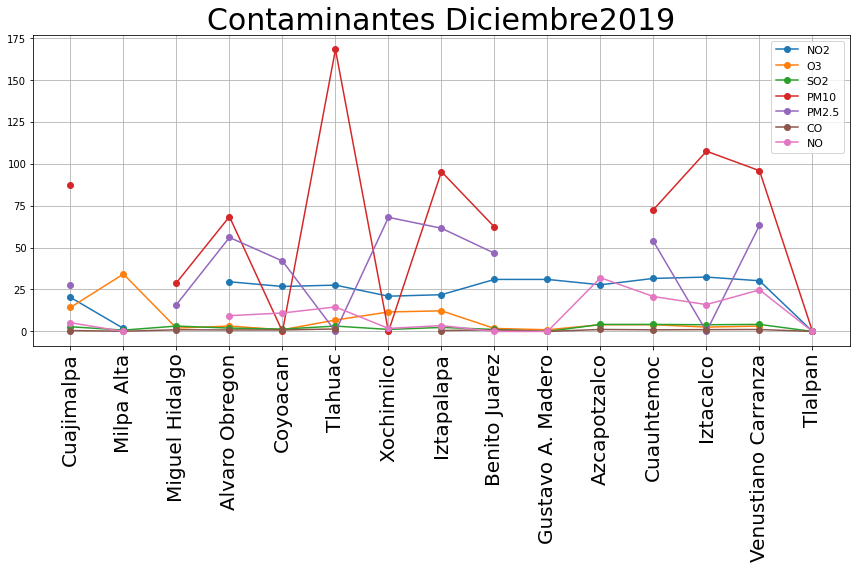

In [32]:
plotea(Diciembre_2019,'Diciembre',año='2019',save=True)

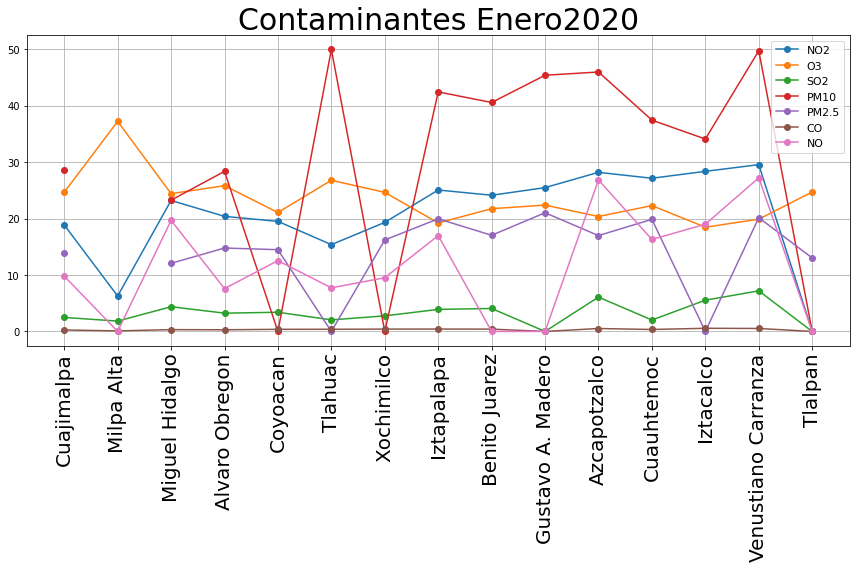

In [33]:
plotea(Enero_2020,'Enero',save=True)

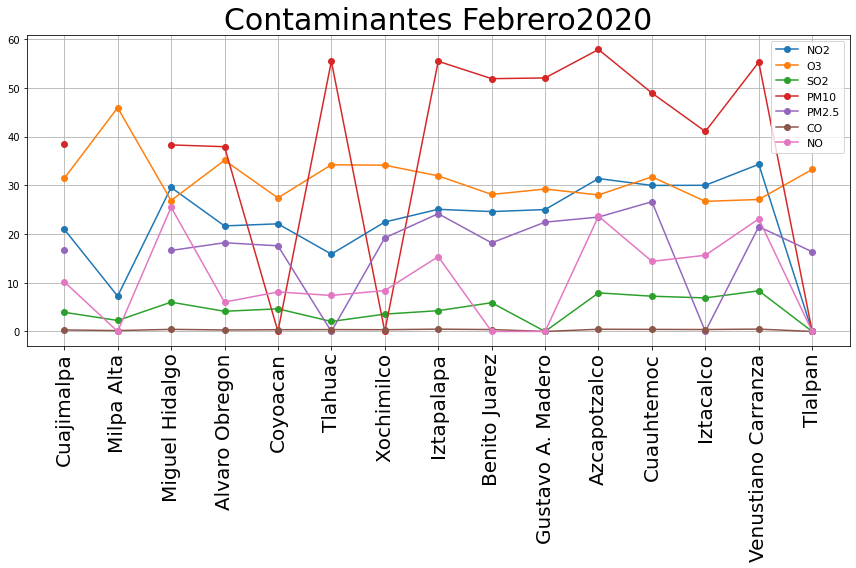

In [34]:
plotea(Febrero_2020,'Febrero',save=True)

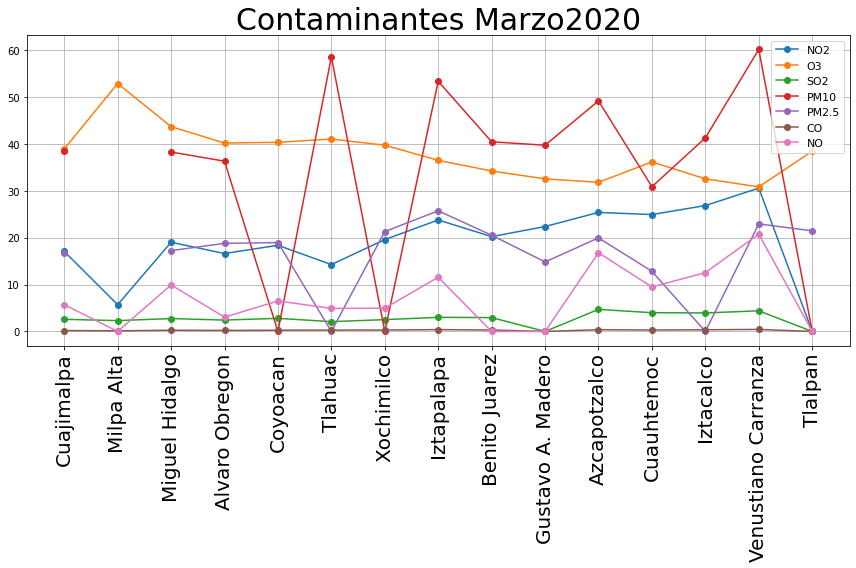

In [35]:
plotea(Marzo_2020,'Marzo',save=True)

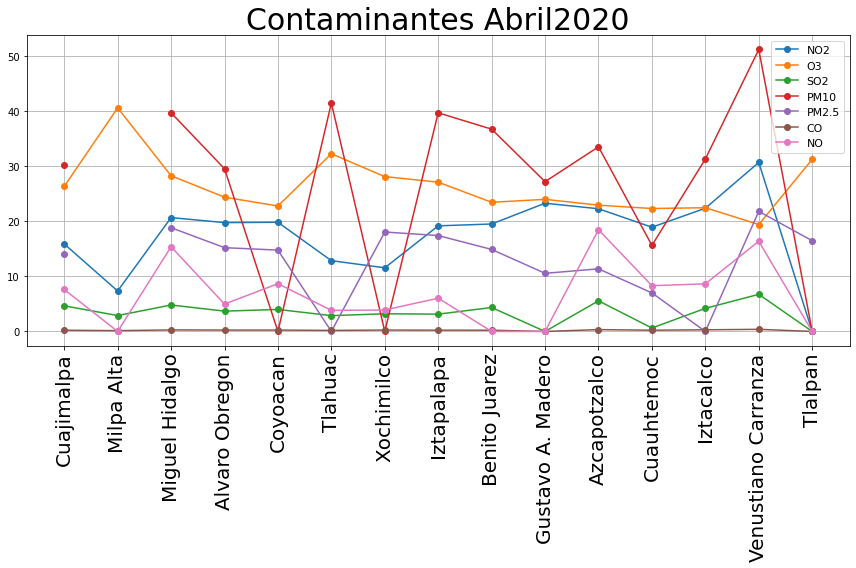

In [36]:
plotea(Abril_2020,'Abril',save=True)

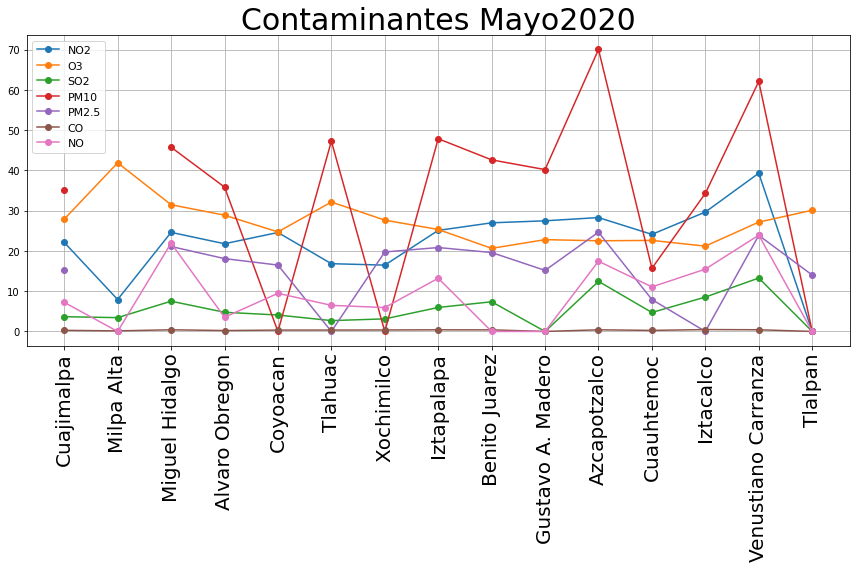

In [37]:
plotea(Mayo_2020,'Mayo',save=True)

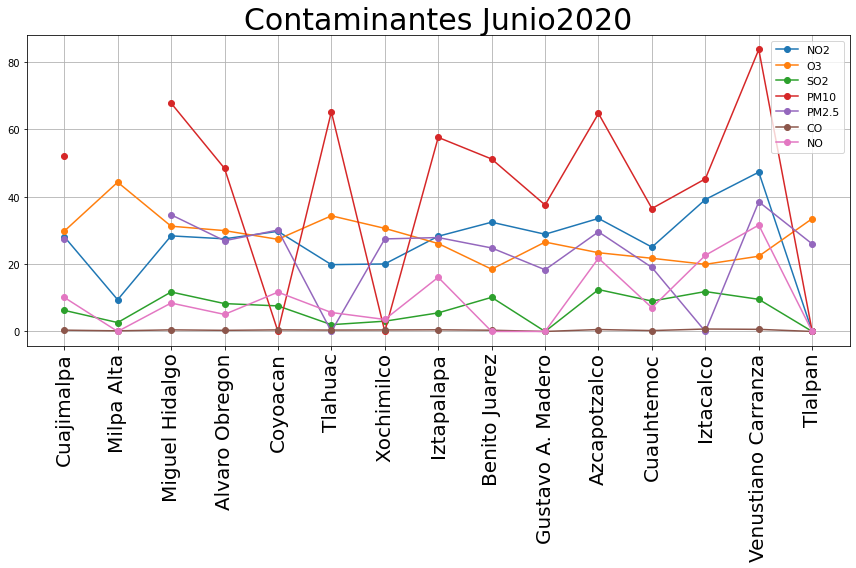

In [38]:
plotea(Junio_2020,'Junio',save=True)

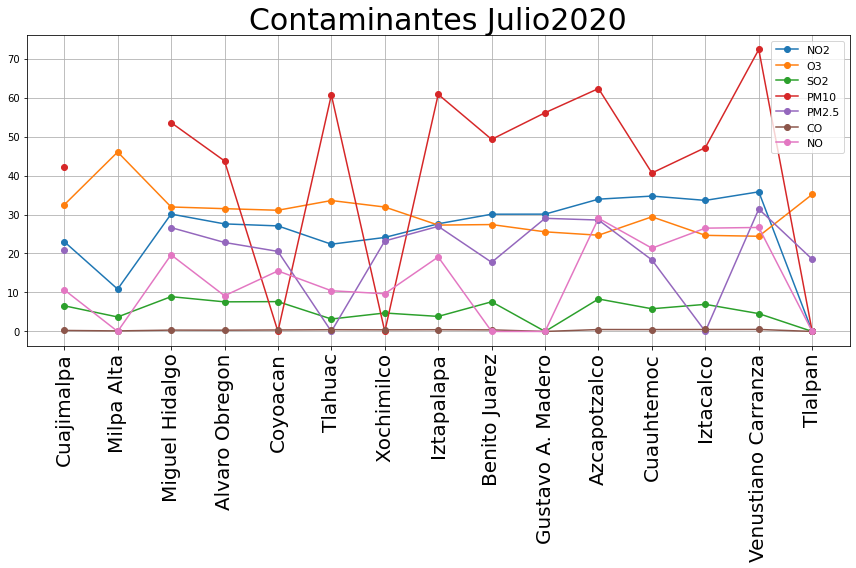

In [39]:
plotea(Julio_2020,'Julio',save=True)

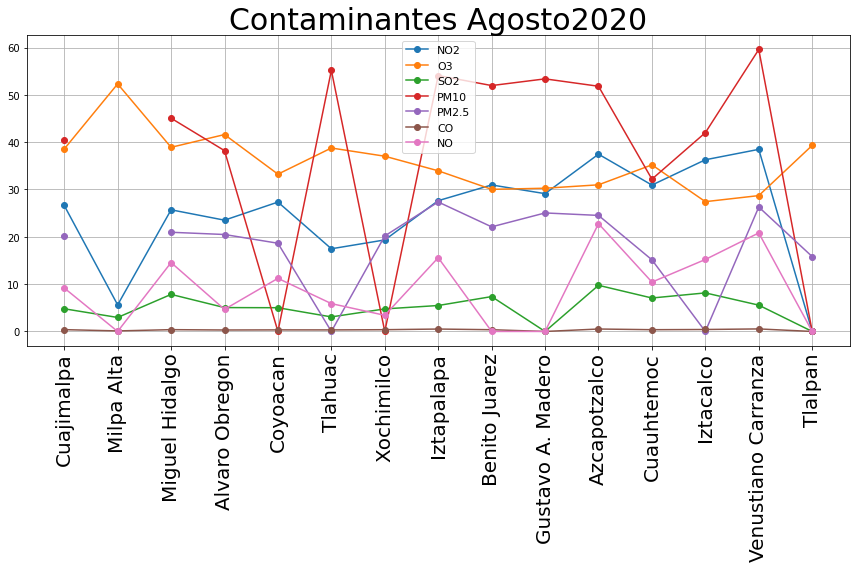

In [40]:
plotea(Agosto_2020,'Agosto',save=True)

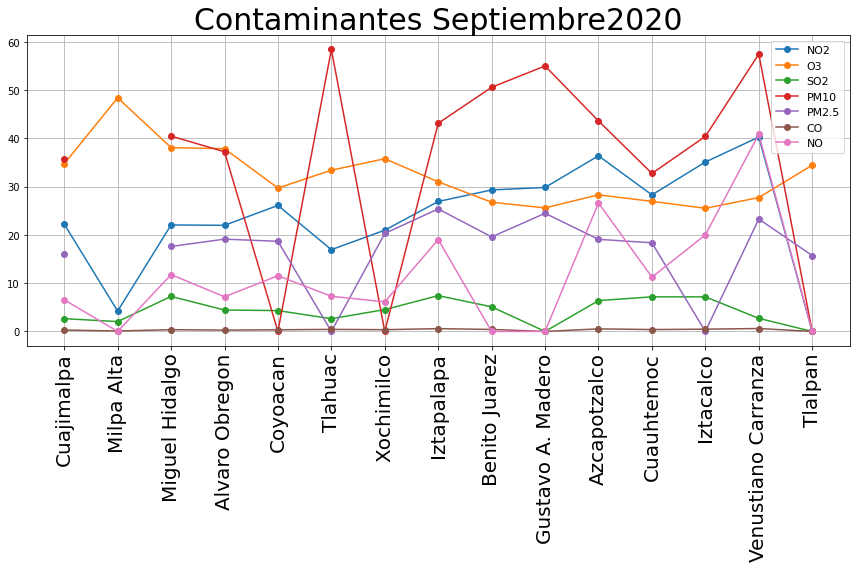

In [41]:
plotea(Septiembre_2020,'Septiembre',save=True)

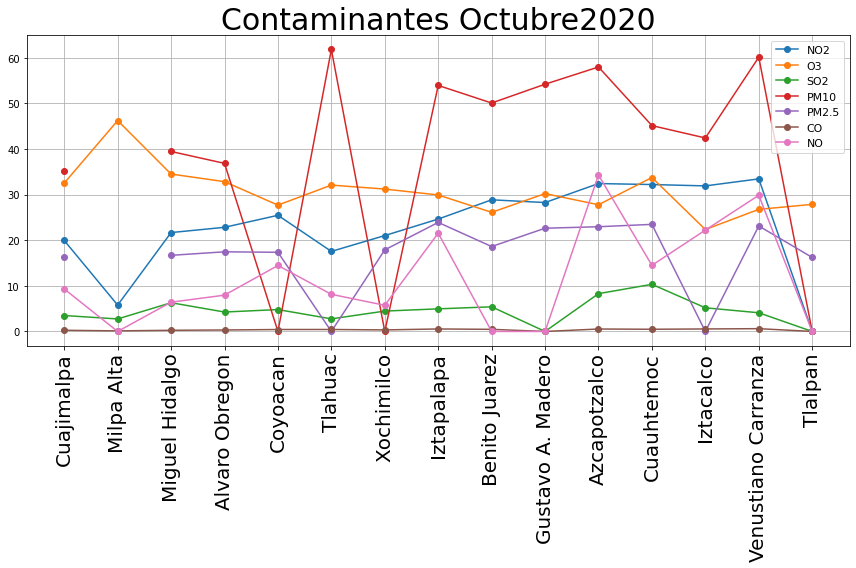

In [42]:
plotea(Octubre_2020,'Octubre',save=True)

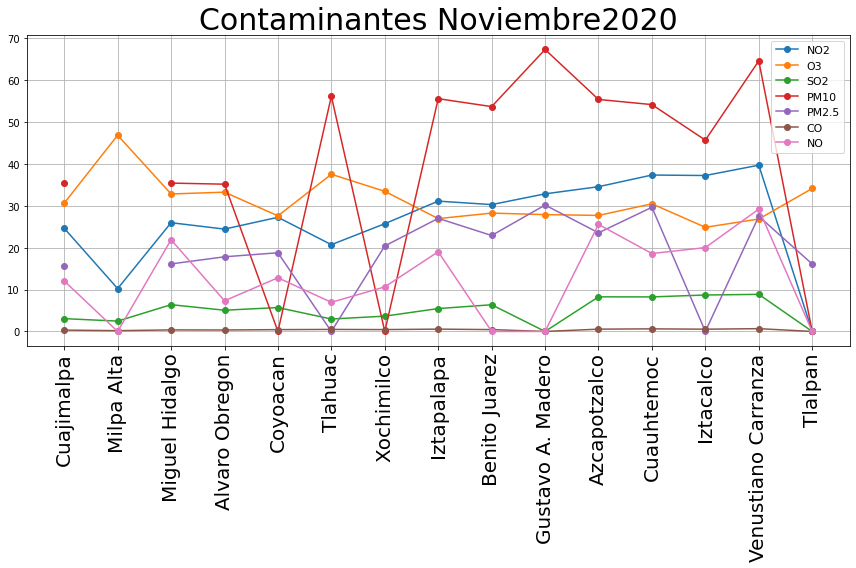

In [43]:
plotea(Noviembre_2020,'Noviembre',save=True)

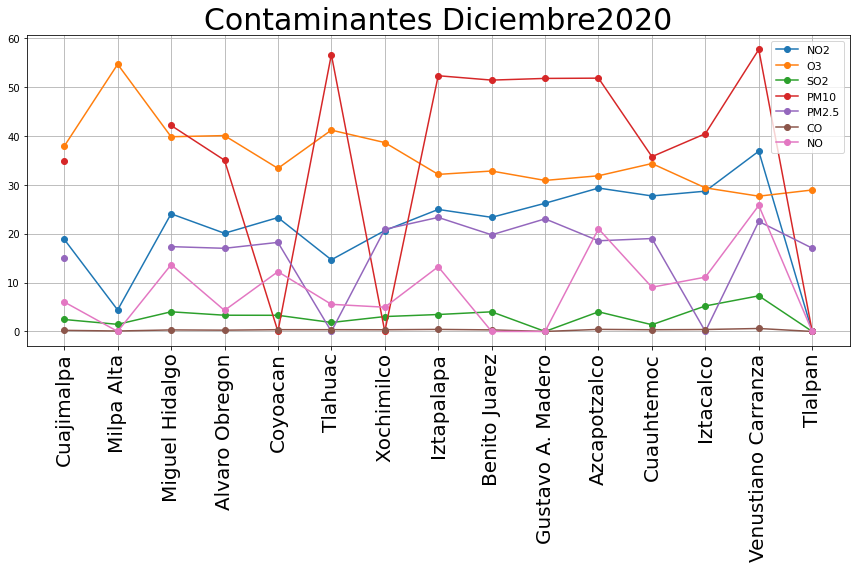

In [44]:
plotea(Diciembre_2020,'Diciembre',save=True,formato='png')